In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [3]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend

Using notebook 3d backend.


In [3]:
PHONEME_PATH = '/cwork/ns458/BIDS-1.4_Phoneme_sequencing/BIDS/'
TIMIT_PATH = '/cwork/ns458/BIDS-1.0_TIMIT/BIDS/'
SENTENCE_PATH = '/cwork/ns458/BIDS-1.4_SentenceRep/BIDS/'

In [4]:
# 获取每个数据集的subjects
def get_subjects(bids_path):
    """从BIDS目录获取所有subject ID"""
    path = Path(bids_path)
    subjects = sorted([d.name.replace('sub-', '') for d in path.iterdir() 
                      if d.is_dir() and d.name.startswith('sub-')])
    return set(subjects)

# 获取三个数据集的subjects
phoneme_subs = get_subjects(PHONEME_PATH)
timit_subs = get_subjects(TIMIT_PATH)
sentence_subs = get_subjects(SENTENCE_PATH)

# 创建结构化DataFrame
all_subs = sorted(phoneme_subs | timit_subs | sentence_subs)
df = pd.DataFrame({
    'subject': all_subs,
    'Phoneme': [s in phoneme_subs for s in all_subs],
    'TIMIT': [s in timit_subs for s in all_subs],
    'SentenceRep': [s in sentence_subs for s in all_subs]
})

# 添加任务计数列
df['n_tasks'] = df[['Phoneme', 'TIMIT', 'SentenceRep']].sum(axis=1)

print(f"Phoneme: {len(phoneme_subs)} subjects")
print(f"TIMIT: {len(timit_subs)} subjects")
print(f"SentenceRep: {len(sentence_subs)} subjects")
print(f"Total unique: {len(all_subs)} subjects")
print(f"\\nDataFrame shape: {df.shape}")
df.head(10)

Phoneme: 50 subjects
TIMIT: 36 subjects
SentenceRep: 34 subjects
Total unique: 71 subjects
\nDataFrame shape: (71, 5)


,subject,Phoneme,TIMIT,SentenceRep,n_tasks
0,D0005,False,False,True,1
1,D0007,False,False,True,1
2,D0008,False,False,True,1
3,D0009,False,False,True,1
4,D0015,False,False,True,1
5,D0016,False,False,True,1
6,D0017,False,False,True,1
7,D0018,False,False,True,1
8,D0019,True,False,False,1
9,D0020,False,False,True,1


In [35]:
total_subject_task = int(df['n_tasks'].sum())
print(f"Total subject-task instances (unique): {total_subject_task}")

Total subject-task instances (unique): 120


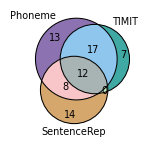

In [33]:
# 三元Venn图可视化
from matplotlib_venn import venn3, venn3_circles

fig, ax = plt.subplots(figsize=(4*cm, 4*cm))

# 创建Venn图 - 使用集合
v = venn3([phoneme_subs, timit_subs, sentence_subs], 
          set_labels=('Phoneme', 'TIMIT', 'SentenceRep'),
          set_colors = ('#8C72B0', '#40A9A3', '#D6A76D'),  # red, blue, 暖灰金,
          alpha=1,
          ax=ax)

# add circle
venn3_circles([phoneme_subs, timit_subs, sentence_subs], 
              linewidth=0.75, ax=ax)

# set fontsize
for text in v.set_labels:
    if text:
        text.set_fontsize(fontsize)

for text in v.subset_labels:
    if text:
        text.set_fontsize(fontsize)

plt.tight_layout()
plt.show()
